# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [185]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file   = 'train.p'
validation_file = 'valid.p'
testing_file    = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [186]:
print (X_train.shape, y_train.shape)
print (X_valid.shape, y_valid.shape)
print (X_test.shape, y_test.shape)

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

(34799, 32, 32, 3) (34799,)
(4410, 32, 32, 3) (4410,)
(12630, 32, 32, 3) (12630,)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train[0].shape
n_classes = 43

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


###  Exploratory visualization of the dataset

43


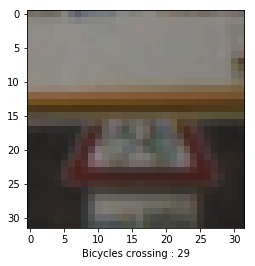

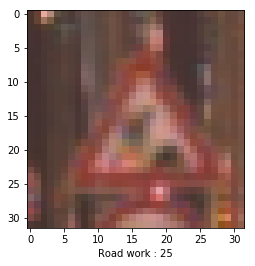

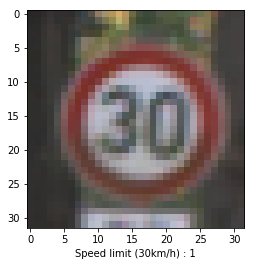

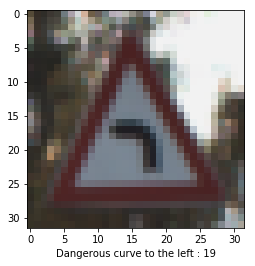

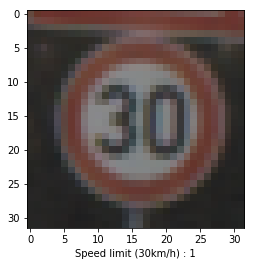

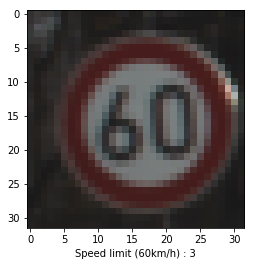

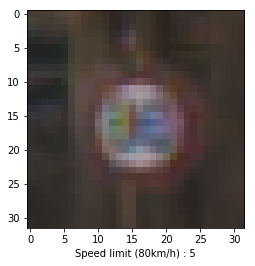

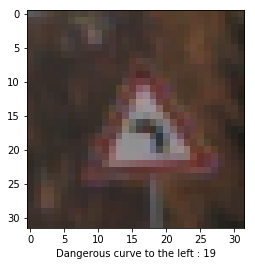

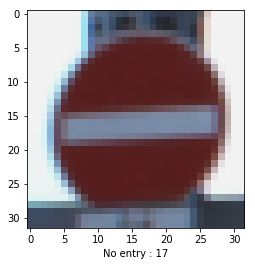

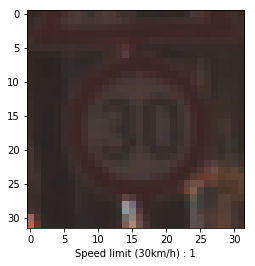

In [22]:
import random
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Read the sign names for each id (from signnames.csv) and keep in 
# a dictionary for easy access
signnames_dict = {}

with open('signnames.csv', mode='r') as file:
    reader = csv.reader(file)
    next(reader, None)
    signnames_dict = {int(k):v for k, v in reader}

for row in range(1,11):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    plt.imshow(image)
    plt.xlabel(signnames_dict[int(y_train[index])] + " : " + str(int(y_train[index])))
    plt.show()

Text(0.5, 0, 'Histogram of test set labels')

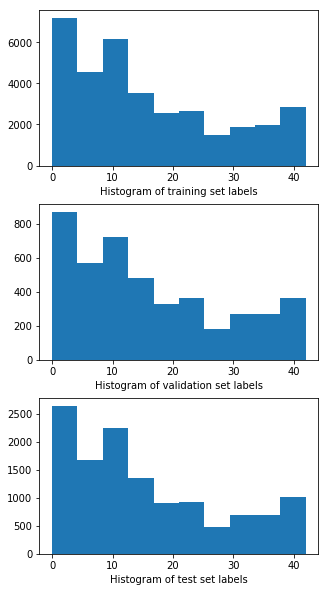

In [5]:
# Histogram of labels in training data
plt.figure(figsize=(5, 10))
plt.subplots_adjust(hspace=0.25)

plt.subplot(3,1,1)
plt.hist(y_train)
plt.xlabel("Histogram of training set labels")

plt.subplot(3,1,2)
plt.hist(y_valid)
plt.xlabel("Histogram of validation set labels")

plt.subplot(3,1,3)
plt.hist(y_test)
plt.xlabel("Histogram of test set labels")

In [6]:
print (signnames_dict[0])
print (signnames_dict[1])
print (signnames_dict[2])
print (signnames_dict[4])

Speed limit (20km/h)
Speed limit (30km/h)
Speed limit (50km/h)
Speed limit (70km/h)


----

## Step 2: Design and Test of Model Architecture


### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [7]:
# Scale data between 0.1 and 0.9
def scale1(x):
    return 0.05 + (0.9*x)/255

In [8]:
def normalize1(x):
    return (x - 128)/128

In [9]:
# Normalize train, validate and test set
X_train = scale1(X_train)
X_valid = scale1(X_valid)
X_test = scale1(X_test)

In [10]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [11]:
import tensorflow as tf

EPOCHS = 250
BATCH_SIZE = 200

### Model Architecture

In [12]:
from tensorflow.contrib.layers import flatten

def LeNetDerived_3Channel(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    wc1 = tf.Variable(tf.random_normal([5, 5, 3, 6], mean=mu, stddev=sigma))
    bc1 = tf.Variable(tf.random_normal([6], mean=mu, stddev=sigma))
    x = tf.nn.conv2d(x, wc1, strides=[1, 1, 1, 1], padding='VALID')
    x = tf.nn.bias_add(x, bc1)
    
    # Adding dropout early in CNN
    x = tf.nn.dropout(x, 0.50)
        
    # Activation.
    x = tf.nn.relu(x)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Layer 2: Convolutional. Input = 14x14x6, Output = 10x10x16.
    wc2 = tf.Variable(tf.random_normal([5, 5, 6, 16], mean=mu, stddev=sigma))
    bc2 = tf.Variable(tf.random_normal([16], mean=mu, stddev=sigma))
    x = tf.nn.conv2d(x, wc2, strides=[1, 1, 1, 1], padding='VALID')
    x = tf.nn.bias_add(x, bc2)
    
    # Activation.
    x = tf.nn.relu(x)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Flatten. Input = 5x5x16. Output = 400.
    x = flatten(x)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    wfc1 = tf.Variable(tf.random_normal([400, 120], mean=mu, stddev=sigma))
    bfc1 = tf.Variable(tf.random_normal([120], mean=mu, stddev=sigma))
    x = tf.add(tf.matmul(x, wfc1), bfc1)
    
    # Activation.
    x = tf.nn.relu(x)
    
    # Layer 4: Fully Connected. Input = 120. Output = 80.
    wfc2 = tf.Variable(tf.random_normal([120, 80], mean=mu, stddev=sigma))
    bfc2 = tf.Variable(tf.random_normal([80], mean=mu, stddev=sigma))
    x = tf.add(tf.matmul(x, wfc2), bfc2)
    
    # Activation.
    x = tf.nn.relu(x)

    # Layer 5: Fully Connected. Input = 80. Output = 43.
    wfc3 = tf.Variable(tf.random_normal([80, 43], mean=mu, stddev=sigma))
    bfc3 = tf.Variable(tf.random_normal([43], mean=mu, stddev=sigma))
    logits = tf.add(tf.matmul(x, wfc3), bfc3)
    
    return logits

### Train, Validate and Test the Model

In [13]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [14]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [15]:
rate = 0.001

logits = LeNetDerived_3Channel(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [16]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [17]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.654

EPOCH 2 ...
Validation Accuracy = 0.777

EPOCH 3 ...
Validation Accuracy = 0.831

EPOCH 4 ...
Validation Accuracy = 0.830

EPOCH 5 ...
Validation Accuracy = 0.831

EPOCH 6 ...
Validation Accuracy = 0.878

EPOCH 7 ...
Validation Accuracy = 0.873

EPOCH 8 ...
Validation Accuracy = 0.884

EPOCH 9 ...
Validation Accuracy = 0.891

EPOCH 10 ...
Validation Accuracy = 0.898

EPOCH 11 ...
Validation Accuracy = 0.881

EPOCH 12 ...
Validation Accuracy = 0.889

EPOCH 13 ...
Validation Accuracy = 0.901

EPOCH 14 ...
Validation Accuracy = 0.899

EPOCH 15 ...
Validation Accuracy = 0.898

EPOCH 16 ...
Validation Accuracy = 0.897

EPOCH 17 ...
Validation Accuracy = 0.892

EPOCH 18 ...
Validation Accuracy = 0.902

EPOCH 19 ...
Validation Accuracy = 0.904

EPOCH 20 ...
Validation Accuracy = 0.898

EPOCH 21 ...
Validation Accuracy = 0.901

EPOCH 22 ...
Validation Accuracy = 0.908

EPOCH 23 ...
Validation Accuracy = 0.907

EPOCH 24 ...
Validation Accura

EPOCH 194 ...
Validation Accuracy = 0.927

EPOCH 195 ...
Validation Accuracy = 0.922

EPOCH 196 ...
Validation Accuracy = 0.929

EPOCH 197 ...
Validation Accuracy = 0.927

EPOCH 198 ...
Validation Accuracy = 0.924

EPOCH 199 ...
Validation Accuracy = 0.922

EPOCH 200 ...
Validation Accuracy = 0.932

EPOCH 201 ...
Validation Accuracy = 0.930

EPOCH 202 ...
Validation Accuracy = 0.921

EPOCH 203 ...
Validation Accuracy = 0.932

EPOCH 204 ...
Validation Accuracy = 0.931

EPOCH 205 ...
Validation Accuracy = 0.925

EPOCH 206 ...
Validation Accuracy = 0.929

EPOCH 207 ...
Validation Accuracy = 0.923

EPOCH 208 ...
Validation Accuracy = 0.922

EPOCH 209 ...
Validation Accuracy = 0.929

EPOCH 210 ...
Validation Accuracy = 0.924

EPOCH 211 ...
Validation Accuracy = 0.933

EPOCH 212 ...
Validation Accuracy = 0.926

EPOCH 213 ...
Validation Accuracy = 0.926

EPOCH 214 ...
Validation Accuracy = 0.928

EPOCH 215 ...
Validation Accuracy = 0.922

EPOCH 216 ...
Validation Accuracy = 0.924

EPOCH 217 .

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

In [94]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_valid, y_valid)
    print("Test Accuracy on validation set = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy on validation set = 0.932


In [95]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy on test set = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy on test set = 0.923


In [96]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_train, y_train)
    print("Test Accuracy on training set = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy on training set = 0.999


### Load and Output the Images

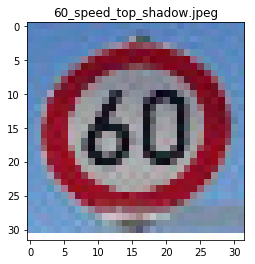

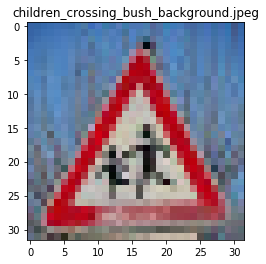

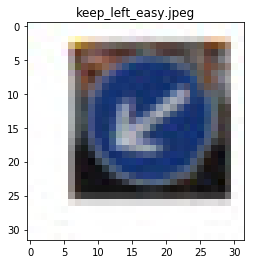

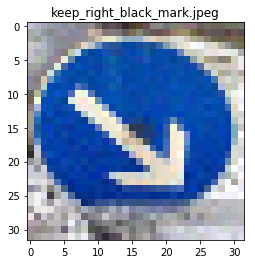

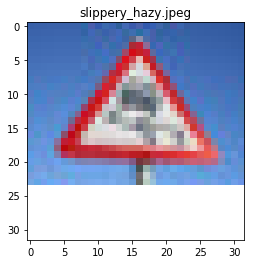

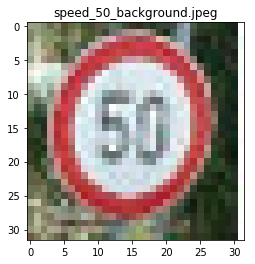

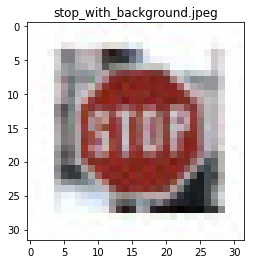

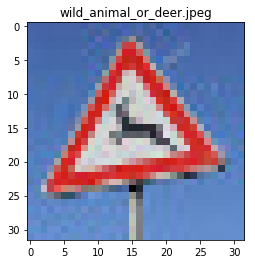

Number of web test images: (8, 32, 32, 3)


In [170]:
# 8 test images from the web (Google images)
import os
import matplotlib.image as mpimage

web_test_files = os.listdir('test_images')
X_web_test = []

for i in range(len(web_test_files)):
    img = mpimage.imread('test_images/'+web_test_files[i])
    plt.imshow(img)
    plt.title(web_test_files[i])
    assert(img.shape == (32,32,3))
    plt.show()
    X_web_test.append(img)

X_web_test = np.array(X_web_test)
print("Number of web test images:", X_web_test.shape)

### Predict the Sign Type for Each Image

In [171]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
predict_operation = tf.argmax(logits,1)
top5_operation = tf.nn.top_k(tf.nn.softmax(logits), k=5)

def estimate(X_data):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    prediction = sess.run(predict_operation, feed_dict={x: X_data })
    top5 = sess.run(top5_operation, feed_dict={x: X_data})
    return prediction, top5

INFO:tensorflow:Restoring parameters from ./lenet
Predicted Sign: Speed limit (60km/h)


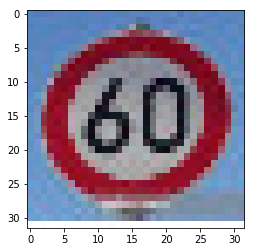

Predicted Sign: Children crossing


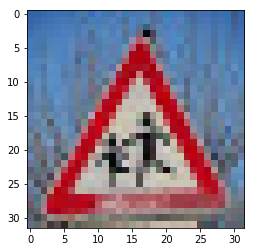

Predicted Sign: Keep left


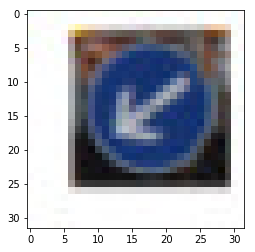

Predicted Sign: Keep right


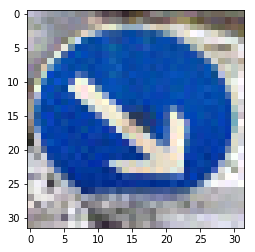

Predicted Sign: No entry


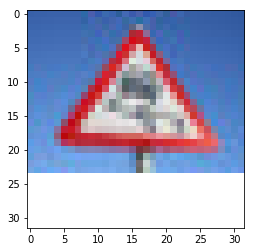

Predicted Sign: Speed limit (50km/h)


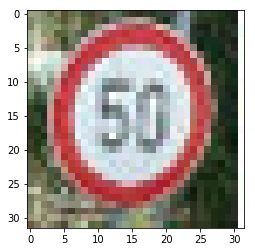

Predicted Sign: Stop


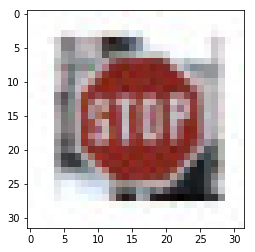

Predicted Sign: Right-of-way at the next intersection


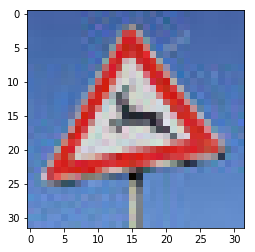

In [172]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    X_web_test_scaled = scale1(X_web_test)
    estimations, top5 = estimate(X_web_test_scaled)

    for i in range(len(estimations)):
        print ("Predicted Sign: " + signnames_dict[estimations[i]])
        plt.imshow(X_web_test[i])
        plt.show()

### Analyze Performance

In [184]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

n_total_web_images = 8
n_correct_classified = 6
print ("Model accuracy on web images = ", 100 * (n_correct_classified/n_total_web_images), "%")

Model accuracy on web images =  75.0 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [179]:
print (top5)

TopKV2(values=array([[1.00000000e+00, 2.95345899e-08, 8.86098053e-12, 3.56401313e-19,
        1.31366419e-21],
       [1.00000000e+00, 1.10364835e-15, 4.04554516e-17, 7.78317664e-21,
        2.60380206e-25],
       [1.00000000e+00, 1.76877446e-09, 7.70866183e-12, 6.15726263e-12,
        4.78928485e-12],
       [1.00000000e+00, 4.56422387e-32, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.00000000e+00, 4.39094212e-11, 2.58648506e-12, 1.36491394e-17,
        7.76308023e-19],
       [1.00000000e+00, 9.72621428e-10, 9.12101839e-10, 7.99008381e-15,
        6.60944849e-15],
       [9.99981046e-01, 1.89579150e-05, 1.00439385e-13, 3.73267931e-17,
        4.54342361e-20],
       [6.67036653e-01, 2.88644999e-01, 4.42724936e-02, 2.88001811e-05,
        7.57792577e-06]], dtype=float32), indices=array([[ 3,  2,  5,  1, 35],
       [28, 30, 11, 26, 20],
       [39, 33, 34, 38, 13],
       [38, 40,  0,  1,  2],
       [17, 14, 10, 11,  3],
       [ 2,  1,  5,  7,  4],
       [14,